In [1]:
#Import all of the necessary packages
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from IPython.html.widgets import interact, fixed
import ipywidgets as widgets

import io

font_plt = {'family': 'serif',
            'color':  'darkred',
            'weight': 'normal',
            'size': 10,
            }
font_plt_ax = {'family': 'serif',
               'color':  'black',
               'weight': 'normal',
               'size': 10,
              }
import sys
import glob #glob is helpful for searching for filenames or directories
import ddm_clean as ddm #this is the module containing the differential dynamic microscopy code
import scipy #scientific python
from scipy.signal import blackmanharris as bh #for Blackman-Harris windowing
import pickle #for saving data

import mpld3

C:\Users\Physics\Anaconda3\lib\site-packages\IPython\html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)
tiff_file.py:1995: UserWarning: failed to import _tifffile.decodepackbits
  warnings.warn("failed to import %s" % module_function)
tiff_file.py:1995: UserWarning: failed to import _tifffile.decodelzw
  warnings.warn("failed to import %s" % module_function)
tiff_file.py:1995: UserWarning: failed to import _tifffile.unpackints
  warnings.warn("failed to import %s" % module_function)


In [326]:
Sample = ['0.02mgmlDNA_Buffer_17.5fps_55exp_8000frames', '0.02mgmlDNA_Buffer_49fps_20exp_8000frames','0.02mgmlDNA_Buffer_99fps_10exp_8000frames','0.02mgmlDNA_Buffer_99fps_10exp']
Sample = ['allResults_0.02mgmlDNA_MTNetwork_29fps_34exp'] 

In [408]:
# different ROIs and the video number, change samNumber based upon the number of videos taken for the condition
ROI = ['0', '128', '256', '384', '512', '640']#, '768', '896']
samNumber = ['1','2','3','4','5']
newtaus = np.zeros([len(samNumber),31])
newtaustds = np.zeros([len(samNumber),31])

In [432]:
Round2_Results = {}

In [403]:
# We only need to load this because of the dts
data_d = "D:\\AllVideos\\"
data_f = Sample[num]+"_"+samNumber[ss]+"_MMStack_Pos0.ome_"+ROI[0]+"_BH_128x128_FFTDIFFS_dts_ravs.p"
dat = pickle.load(open(data_d + data_f,'r'))
dts  = dat['dts']

IOError: [Errno 2] No such file or directory: 'D:\\AllVideos\\allResults_0.02mgmlDNA_MTNetwork_29fps_34exp_3_MMStack_Pos0.ome_0_BH_128x128_FFTDIFFS_dts_ravs.p'

In [416]:
R1 = np.zeros([len(ROI),2])
R2 = np.zeros([len(ROI),2])

In [433]:
num = 0
ss = 0

In [434]:
newt = lambda t,s: (1./s)*gamma(1./s)*t
framerate = 29.0
px = 0.189
imDimension = 128
q = np.arange(0,imDimension/2)*2*np.pi*(1./(imDimension*px))
times = dts/framerate

In [435]:
#Load in the allResults file  
data_dir = "D:\\2018-07-11_videos\\allResults\\"
data_file = Sample[num]+"_"+samNumber[ss]+".p"

Ana_data = pickle.load(open(data_dir + data_file, 'r'))

(0.9, 15)

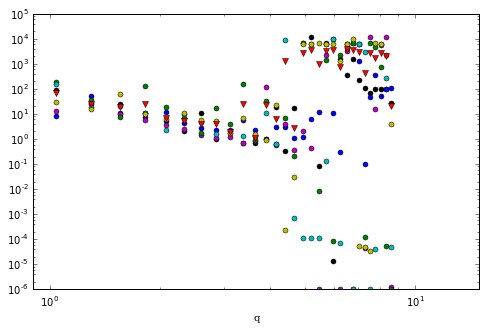

In [436]:
%matplotlib inline
mpld3.enable_notebook()

#This will plot all of the q vs tau for all of the ROIs in the   
tau = np.zeros([len(ROI),63]) #decay time
amp = np.zeros_like(tau) #amplitude
bg = np.zeros_like(tau) #background
alph = np.zeros_like(tau) #alpha (stretching exponent)
chi2 = np.zeros_like(tau)
#fitparams = np.zeros([63,7])
for i in range(len(ROI)):
    fitparams = Ana_data['fitparams'+ROI[i]]
    tau[i,:] = fitparams[:,1]
    amp[i,:] = fitparams[:,0]
    bg[i,:] = fitparams[:,2]
    alph[i,:] = fitparams[:,3]

fig = plt.figure(figsize=(8,8/1.618)); ax = fig.gca(); 
ax.set_xlabel("q", fontdict=font_plt_ax)

nt = np.zeros([7,31])
cols = ['ko','bo','mo','go','co','yo']
for i in range(len(ROI)):
    nt[i] = ddm.newt(tau[i,2:-30], alph[i,2:-30])
    ax.loglog(q[3:-30], ddm.newt(tau[i,2:-30],alph[i,2:-30]), cols[i], ms= 5.0)

ntav = np.mean(nt, axis=0)
ntstd = np.std(nt,axis=0)

ax.loglog(q[3:-30], ntav, 'rv')
ax.set_xlim(0.9,15)

In [437]:
Round2_Results['newTaus_ROIs'+Sample[num]+'_'+samNumber[ss]] = ntav
Round2_Results['newTausSTD_ROIs'+Sample[num]+'_'+samNumber[ss]] = ntstd

In [438]:
def DiffCoef (newtau_average, StretchExp, qrange, qmin, qmax):
    nt = newtau_average
    indx = (qrange>qmin) & (qrange<qmax)
    ds = (qrange[indx]**-2) / nt[indx]
    return ds.mean(), indx

def Diff_Fit(qrange, taurange, qmin, qmax, StExp, slope):
    step1 = DiffCoef(taurange, StExp, qrange, qmin, qmax)
    fit1 = (1./step1[0]) * 1./(qrange**slope)
    return fit1, step1[0], step1[1]

#Need to fix the function so the it will fit the data
#define a function to plot the results

def plot_results(qmin = q[2], qmax = q[10], slope = 2.0):
    qs = q[3:-45]
    fig,ax = plt.subplots(figsize=(8,8/1.618))
    #ax.loglog(qs, ntav, 'ro')
    ax.errorbar(np.log(qs),np.log(ntav[:-15]), yerr = ntstd[:-15], xerr = None, fmt = 'ro')
    fits = Diff_Fit(qs, ntav[:-15], qmin, qmax, alph[2:-45], slope)
    ax.plot(np.log(qs), np.log(fits[0]),  '-k')
    ax.set_ylim(-2.0,10)
    ax.text(0.55,0.8,'D = %.3f' %fits[1], 
        fontdict=font_plt,horizontalalignment='left', 
        verticalalignment='center', transform=ax.transAxes)
    ax.text(0.55,0.77,'slope = %.2f' %slope, 
        fontdict=font_plt,horizontalalignment='left', 
        verticalalignment='center', transform=ax.transAxes)
    ax.set_ylabel("Amplitude (red); Decay time (s)", fontdict=font_plt_ax)

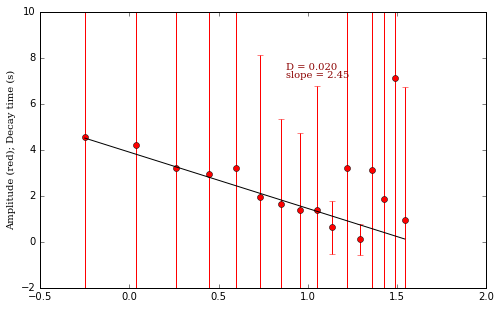

In [439]:
#fit to the low q region
interact(plot_results, qmin = (q[0], q[5]), qmax = (q[5], q[10]), slope = (2.0,4.5,0.05), continuous_update=False)

In [440]:
R1[ss,0] = 0.02
R1[ss,1] = 2.45

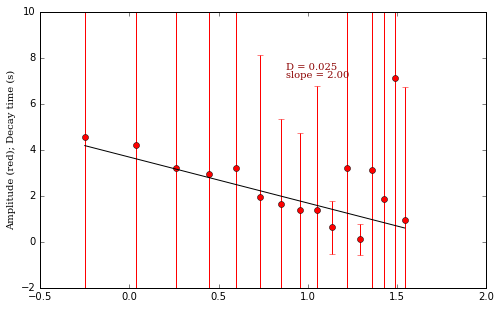

In [441]:
#fit to the high q region
interact(plot_results, qmin = (q[0], q[10]), qmax = (q[5], q[20]), slope = (2.0,4.5,0.05), continuous_update=False)

In [426]:
R2[ss,0] = 0.014
R2[ss,1] = 4.05

In [323]:
Round2_Results['Region1'+Sample[num]] = R1
Round2_Results['Region2'+Sample[num]] = R2

In [325]:
pickle.dump(Round2_Results, open('Z:\\Devynn_Summer2018\\Data\\AllData_Results\\Round2_Results_BufferConditions.p','wb'))

In [ ]:
#Plot the decay time versus the wave vector
fig = plt.figure(figsize=(8,8/1.618)); ax = fig.gca(); 
#ax.loglog(q[3:-1], tau[2:-1], 'ro')
ax.loglog(q[3:-30], ddm.newt(tau[2:-30],alph[2:-30]),'bo')
#ax.loglog(q[3:-30], ddm.newt(tau2[2:-30],alph2[2:-30]),'rv')
diffusion_coeff = 0.25
ax.plot(q[3:-1], (1./diffusion_coeff) * 1./(q[3:-1]**2), '-k')
adiffusion_coeff = 0.25
ax.plot(q[3:-1], (1./adiffusion_coeff) * 1./(q[3:-1]**2.3), '--k')
ax.set_xlabel("q", fontdict=font_plt_ax)

In [85]:
logx = np.log(q[3:-30])
logy = np.log(ntav)
coeffs = np.polyfit(q[3:-30],ntav,deg=1)
coeffs


array([  8.64381232, -22.33492358])

In [ ]:
fig,ax = plt.subplots(figsize=(8,8/1.618))                        
ax.loglog(q[3:-50],yfit(q[3:-50]))
ax.loglog(q[3:-30], ntav, 'rv')

<Container object of 3 artists>

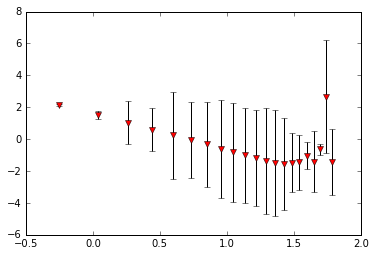

In [52]:
%matplotlib inline
mpld3.enable_notebook()

#fig = plt.figure(figsize=(8,8/1.618)); ax = fig.gca(); 
plt.errorbar(np.log(q[3:-40]), np.log(ntav[:-10]), yerr=np.log(ntstd[:-10]), xerr=None, fmt ='rv', ecolor = 'k')

In [ ]:
print AvgROIs
avgDiffCoeff = np.nanmean(AvgROIs)
stdev = np.nanstd(AvgROIs)
print "Averaged diffusion coefficient is: %.3f " % (avgDiffCoeff)
print "Standard deviation is: %.3f " % (stdev)
allResults['DiffCoeffROIs'] = AvgROIs
allResults['avgDiffCoeff'] = avgDiffCoeff
allResults['stdev'] = stdev